# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy(n):
    N=sum(n)
    e=0
    for i in n:
        p = i/N
        e += -p*np.log(p)
    return e

In [3]:
np.round(entropy([8,2]),2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def Gini(n):
    N =sum(n)
    n = np.array(n)
    n_l = np.full(n.shape,N)
    n_l = n_l - n
    
    g = 0
    for i in n:
        p = i/N
        g +=p*(1-p)
    return g*N

In [5]:
q = np.round(Gini([2,8])/10-(1/10)*Gini([2])-(1/10)*Gini([8]),2)
q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
np.mean([1,10,5,18,100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [7]:
from collections import Counter
from typing import Dict, List, Tuple, Union
from sklearn.preprocessing import LabelEncoder

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [16]:
# Объявление всех доп. функций
def Gini_new(x):
    x_target,x_mask= np.array_split(x,2)
    x_mask = x_mask.astype('bool')
    x_target = x_target[x_mask]
    _,x_n = np.unique(x_target,return_counts=True)
    x_n_l = sum(x_n)-x_n
    g = x_n@x_n_l
    return g/sum(x_n)

def var(x):
    x_target,x_mask= np.array_split(x,2)
    x_mask = x_mask.astype('bool')
    x_target = x_target[x_mask]
    return np.var(x_target)*x_target.size
    

In [106]:
                                   
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    if feature_type == 'categorical':
        if task == 'classification':
            thresholds = np.unique(feature_vector)
            if thresholds.size <= 1:
                return [], [], np.inf, -1
            f_new = np.array(list(map(lambda y_0: np.where(feature_vector==y_0,1,0),thresholds )))
            left = np.column_stack((f_new*target_vector,f_new))
            f_new_1 = np.full((thresholds.size,target_vector.size),1)-f_new
            right = np.column_stack((f_new_1*target_vector,f_new_1))
            ginis = (np.apply_along_axis(Gini_new,1,left)+np.apply_along_axis(Gini_new,1,right))/target_vector.size
            return thresholds,ginis,np.min(ginis),thresholds[ginis.argmin()]
        elif task == 'regression':
            thresholds = np.unique(feature_vector) 
            if thresholds.size <= 1:
                return [], [], np.inf, -1
            f_new = np.array(list(map(lambda y_0: np.where(feature_vector==y_0,1,0),thresholds )))
            left = np.column_stack((f_new*target_vector,f_new))
            f_new_1 = np.full((thresholds.size,target_vector),1)-f_new
            right = np.column_stack((right*target_vector,f_new_1))
            #Хоть и не значения критерия Джини, но чтобы не вводить новые переменные оставлю название то же
            #, тем более что они значат одно и то же.
            ginis = (np.apply_along_axis(var,1,left)+np.apply_along_axis(var,1,right))/target_vector.size
            return thresholds,ginis,np.min(ginis),thresholds[ginis.argmin()]
        else:
            raise ValueError("parameter task has only two possible values :'classification' or 'regression'")
    elif feature_type == 'real':
        if task == 'classification':
            d = np.column_stack((feature_vector, target_vector))
            d = d[d[:,0].argsort()]
            thresholds = (d[1:,0]+d[:-1,0])/2
            f_new = np.array(list(map(lambda y_0: np.where(d[:,0]>=y_0,1,0),thresholds)))
            f_new_1 = np.full((thresholds.size,target_vector.size),1)-f_new
            left = np.column_stack((f_new*d[:,1],f_new))
            right = np.column_stack((f_new_1*d[:,1],f_new_1))
            ginis  = (np.apply_along_axis(Gini_new,1,left)+np.apply_along_axis(Gini_new,1,right))/target_vector.size
            return thresholds,ginis,np.min(ginis),thresholds[ginis.argmin()]
        elif task == 'regression':
            d = np.column_stack((feature_vector, target_vector))
            d = d[d[:,0].argsort()]
            thresholds = (d[1:,0]+d[:-1,0])/2
            f_new = np.array(list(map(lambda y_0: np.where(d[:,0]>=y_0,1,0),thresholds)))
            f_new_1 = np.full((thresholds.size,target_vector.size),1)-f_new
            left = np.column_stack((f_new*d[:,1],f_new))
            print(left.shape)
            right = np.column_stack((f_new_1*d[:,1],f_new_1))
            ginis  = (np.apply_along_axis(var,1,left)+np.apply_along_axis(var,1,right))/target_vector.size
            return thresholds,ginis,np.min(ginis),thresholds[ginis.argmin()]
        else:
            raise ValueError("parameter 'task' has only two possible values :'classification' or 'regression'")
    else:
        raise ValueError("parameter 'feature_type' has only two possible values :'real' or 'categorical'")
        
        



Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [86]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

c:\users\крот\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

In [87]:
X["CRIM"].to_numpy().shape

(506,)

In [88]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

(505, 1012)


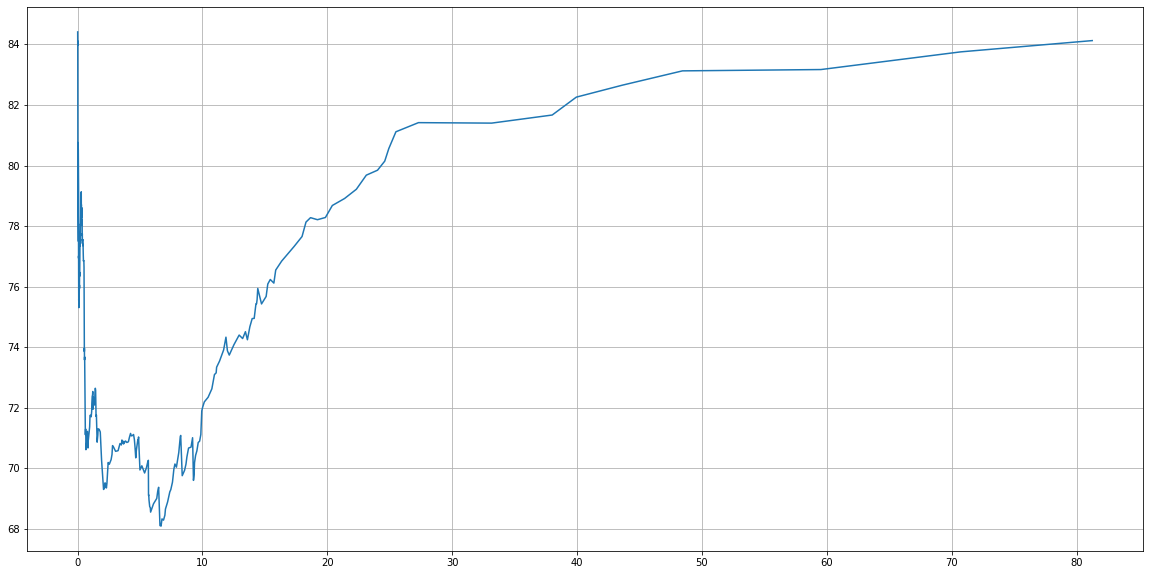

In [89]:
fig = plt.figure(figsize =(20,10))
plt.plot(thresholds,variances)
plt.grid()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [125]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, gini, threshold = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini < gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = np.array(feature_vector<=threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = np.array(feature_vector==threshold_best)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node["type"] == "terminal":
            return node["class"]
        feature_type = self._feature_types[node["feature_split"]]
        if feature_type =="categorical":
            if x[node["feature_split"]]==node["category_split"]:
                return self._predict_node(x,node["left_child"])
            else:
                return self._predict_node(x,node["right_child"])
        else:
            if x[node["feature_split"]]<=node["threshold"]:
                return self._predict_node(x, node["right_child"])
            else:
                return self._predict_node(x, node["left_child"])
                

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [115]:
df = pd.read_csv("students.csv")
df[df.columns[1:]]


,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,1
254,0.78,0.61,0.71,0.19,0.60,1
255,0.54,0.82,0.71,0.29,0.77,1
256,0.50,0.75,0.81,0.61,0.26,1


In [116]:
x = df[df.columns[1:-1]].to_numpy()
y = df[df.columns[-1]].to_numpy()
columns = df.columns[1:-1]

C:\Users\72CD~1\AppData\Local\Temp/ipykernel_15640/3125855904.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  return g/sum(x_n)
C:\Users\72CD~1\AppData\Local\Temp/ipykernel_15640/3125855904.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  return g/sum(x_n)
C:\Users\72CD~1\AppData\Local\Temp/ipykernel_15640/3125855904.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  return g/sum(x_n)


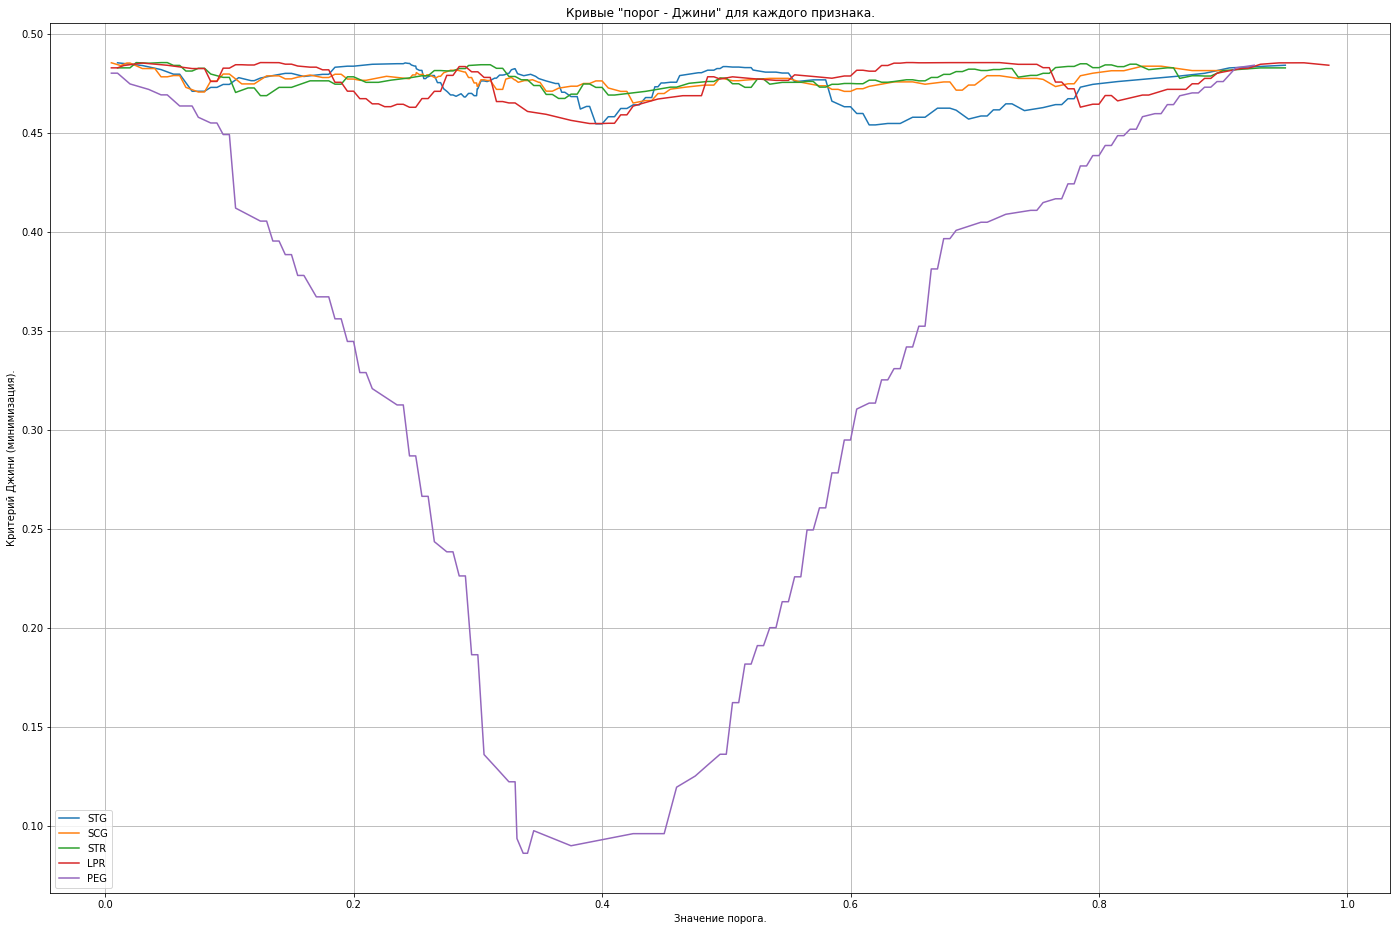

In [117]:
plt.figure(figsize=(24,16))
for i in range(x.shape[1]):
    thresholds,ginis,_,_ = find_best_split(
        x[:,i],y,
        task = 'classification',feature_type='real')
    plt.plot(thresholds,ginis,label = df.columns[i+1])
plt.legend(loc ='best')
plt.grid()
plt.xlabel('Значение порога.')
plt.ylabel('Критерий Джини (минимизация).')
plt.title('Кривые "порог - Джини" для каждого признака.')
plt.show() 

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

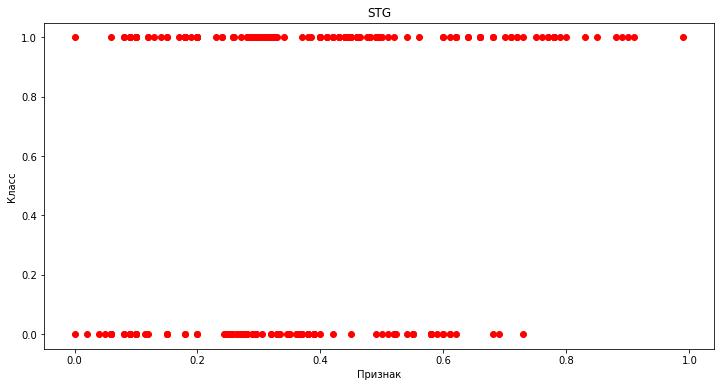

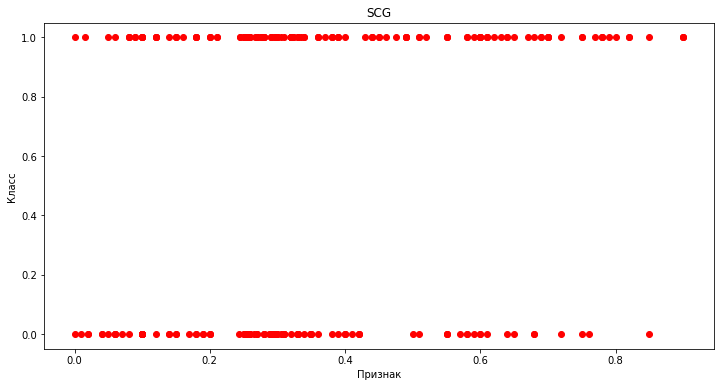

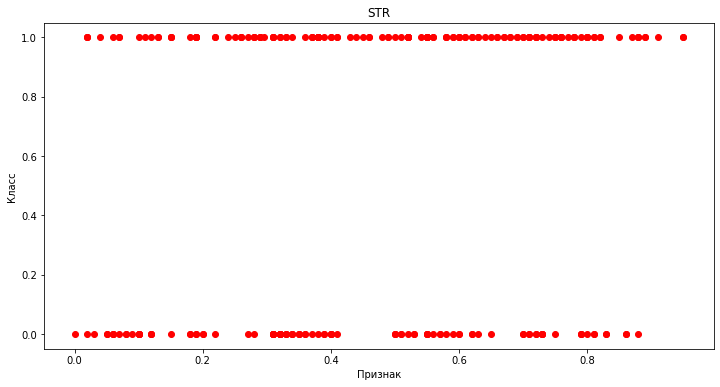

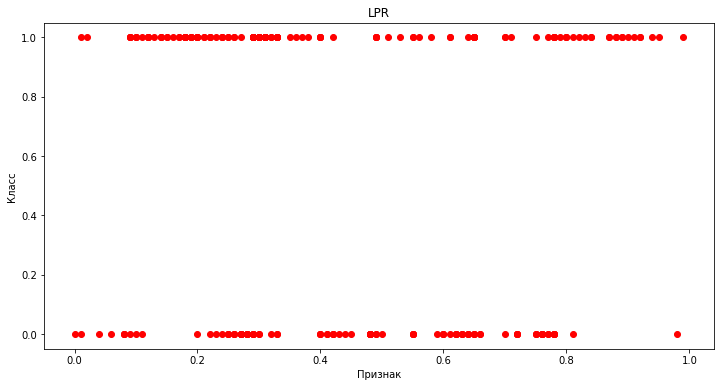

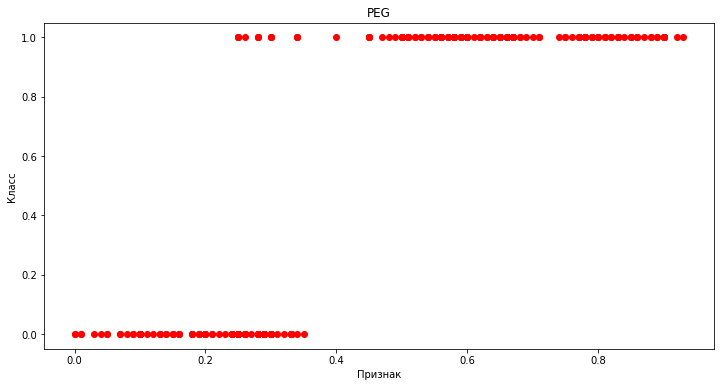

In [118]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12,6))
    plt.scatter(x[:,i], y,color = 'red')
    plt.xlabel("Признак")
    plt.ylabel("Класс")
    plt.title(df.columns[i+1])
    plt.show()

Исходя из кривых "признак - Джини" нужно разбиать по признаку с лейблом: "PEG", т.к. на нем кривые имеют ярко выраженный и самый глубокий минимум. Визуально мы также видим, что выборку можно разделить почти без ошибки по признаку "PEG" со значением порога около 0.4.

Разделение по другим ни исходя из кривой критерия Джини, ни визуально не покажет такого же результата, потому что выборки по одному предикату этого признака так уже хорошо не поделяться и будут пермешанными.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [119]:
!pip install sklearn


You should consider upgrading via the 'c:\users\крот\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [128]:
import sklearn as sk
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

In [129]:
df = pd.read_csv("agaricus-lepiota.data", header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [130]:
l = LabelEncoder()
y  = l.fit_transform(df[0])
x = df[df.columns[1:]].to_numpy()
x = np.apply_along_axis(l.fit_transform,0,x)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)
f_types = np.full(x.shape[1],"categorical")

In [132]:
tree = DecisionTree(f_types)
tree.fit(x_train,y_train)
y_pred = tree.predict(x_test)
accuracy_score(y_test,y_pred)

1.0

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [140]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [134]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

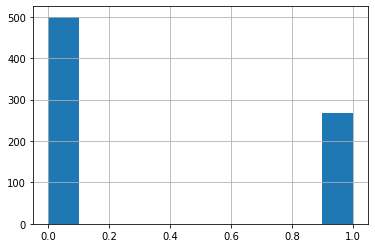

In [135]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [137]:
x = data.drop(columns=['Outcome'])
y = data['Outcome']
x_0, x_test, y_0, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_0, y_0, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [157]:
min_samples_leaf = np.array([2,5,10,15,20,25,30])
max_depth = np.array([5,10,15,20,25,30,35,40])
d = []
n_arr = []
f1 = []
for depth in max_depth:
    for n in min_samples_leaf:
        cl =DecisionTreeClassifier(max_depth= depth, min_samples_leaf= n)
        cl.fit(x_train, y_train) 
        y_pred = cl.predict(x_val)
        d.append(depth)
        n_arr.append(n)
        f1.append(f1_score(y_pred, y_val))
        print('depth=',depth,'min_samples=',n,'f1 =',f1_score(y_pred, y_val))
f1 = np.array(f1)
print(d[f1.argmax()],n_arr[f1.argmax()])

depth= 5 min_samples= 2 f1 = 0.6470588235294117
depth= 5 min_samples= 5 f1 = 0.6666666666666665
depth= 5 min_samples= 10 f1 = 0.6476190476190475
depth= 5 min_samples= 15 f1 = 0.6391752577319587
depth= 5 min_samples= 20 f1 = 0.6391752577319587
depth= 5 min_samples= 25 f1 = 0.5531914893617021
depth= 5 min_samples= 30 f1 = 0.5531914893617021
depth= 10 min_samples= 2 f1 = 0.6285714285714287
depth= 10 min_samples= 5 f1 = 0.5964912280701754
depth= 10 min_samples= 10 f1 = 0.5858585858585859
depth= 10 min_samples= 15 f1 = 0.5617977528089887
depth= 10 min_samples= 20 f1 = 0.5617977528089887
depth= 10 min_samples= 25 f1 = 0.5531914893617021
depth= 10 min_samples= 30 f1 = 0.5531914893617021
depth= 15 min_samples= 2 f1 = 0.6407766990291263
depth= 15 min_samples= 5 f1 = 0.5818181818181819
depth= 15 min_samples= 10 f1 = 0.5858585858585859
depth= 15 min_samples= 15 f1 = 0.5617977528089887
depth= 15 min_samples= 20 f1 = 0.5617977528089887
depth= 15 min_samples= 25 f1 = 0.5531914893617021
depth= 15 min

In [165]:
cl = DecisionTreeClassifier(max_depth = 5, min_samples_leaf= 5)
cl.fit(x_0, y_0)
y_pred = cl.predict(x_test)
print('accuracy: ',accuracy_score(y_pred, y_test))
print('prescision: ',precision_score(y_pred, y_test))
print('recall:', recall_score(y_pred, y_test))
print('auc-roc:', roc_auc_score(y_pred, y_test))

accuracy:  0.7705627705627706
prescision:  0.5625
recall: 0.7142857142857143
auc-roc: 0.7529761904761905


Нормально обучился, однако prescision мог бы быть и побольше

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [151]:
bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=50)
bg.fit(x_0,y_0)
y_bg_pred = bg.predict(x_test)
print('accuracy: ',accuracy_score(y_bg_pred, y_test))
print('prescision: ',precision_score(y_bg_pred, y_test))
print('recall:', recall_score(y_bg_pred, y_test))
print('auc-roc:', roc_auc_score(y_bg_pred, y_test))

accuracy:  0.7402597402597403
prescision:  0.6375
recall: 0.6219512195121951
auc-roc: 0.7136601735144869


Чуть хуже (auc-roc хуже). precision выше, однако recall ниже. В обще обучился неплохо, однако в целом хуже первой модели

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [169]:
min_samples_leaf = np.array([2,5,10,15,20,25,30])
max_depth = np.array([5,10,15,20,25,30,35,40])
d = []
n_arr = []
cr_mean = []
for depth in max_depth:
    for n in min_samples_leaf:
        cl =RandomForestClassifier(n_estimators=50,max_depth= depth, min_samples_leaf= n)
        cross = cross_val_score(cl,x_0, y_0,cv = 4,scoring='f1')
        d.append(depth)
        n_arr.append(n)
        cr_mean.append(cross.mean())
        print('depth=',depth,'min_samples=',n,'f1 =',cross.mean())
cr = np.array(cr_mean)
print(d[cr.argmax()],n_arr[cr.argmax()])

depth= 5 min_samples= 2 f1 = 0.6261002531118802
depth= 5 min_samples= 5 f1 = 0.6272670332783077
depth= 5 min_samples= 10 f1 = 0.5946967782051789
depth= 5 min_samples= 15 f1 = 0.6028169822145726
depth= 5 min_samples= 20 f1 = 0.6051879421391616
depth= 5 min_samples= 25 f1 = 0.5959285131869263
depth= 5 min_samples= 30 f1 = 0.585248759671096
depth= 10 min_samples= 2 f1 = 0.6333116796209585
depth= 10 min_samples= 5 f1 = 0.6438470439155558
depth= 10 min_samples= 10 f1 = 0.5879649404502089
depth= 10 min_samples= 15 f1 = 0.613625441938695
depth= 10 min_samples= 20 f1 = 0.6015212661168203
depth= 10 min_samples= 25 f1 = 0.5921604938271605
depth= 10 min_samples= 30 f1 = 0.6192820649687356
depth= 15 min_samples= 2 f1 = 0.6492011946400706
depth= 15 min_samples= 5 f1 = 0.6223173205362885
depth= 15 min_samples= 10 f1 = 0.6089936913338805
depth= 15 min_samples= 15 f1 = 0.5919428439777277
depth= 15 min_samples= 20 f1 = 0.5890599063383873
depth= 15 min_samples= 25 f1 = 0.5933511330319962
depth= 15 min_s

In [176]:
tr = RandomForestClassifier(n_estimators= 50, max_depth= 20, min_samples_split= 2)
tr.fit(x_0, y_0)
y_rf_pred = tr.predict(x_test)
print('accuracy: ',accuracy_score(y_rf_pred, y_test))
print('prescision: ',precision_score(y_rf_pred, y_test))
print('recall:', recall_score(y_rf_pred, y_test))
print('auc-roc:', roc_auc_score(y_rf_pred, y_test))

accuracy:  0.7619047619047619
prescision:  0.6875
recall: 0.6470588235294118
auc-roc: 0.7379129734085415


В целом лучше чем остальные модели по всем параметрам, хотя и не сильно. сильнее всего заметно различие в precsion с 1ой моедлью

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [192]:
n = np.linspace(1,500,250)
n = n.astype('int')
auc = []
for k in n:
    cl = RandomForestClassifier(n_estimators=k, min_samples_split= 15)
    cl.fit(x_0, y_0)
    y_pred= cl.predict(x_test)
    auc.append(roc_auc_score(y_test, y_pred))

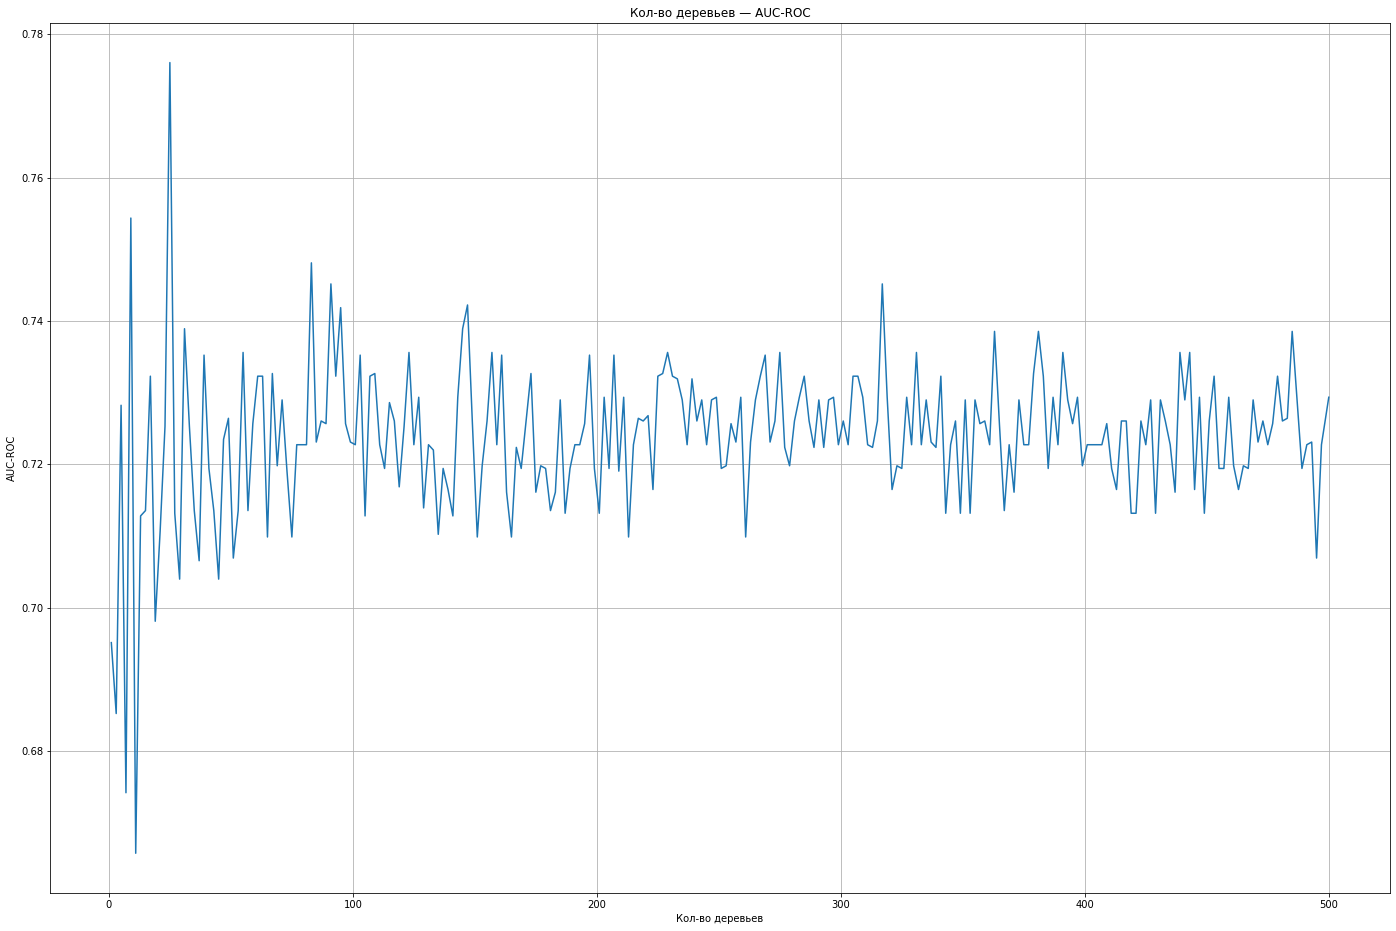

In [193]:
plt.figure(figsize=(24, 16))
plt.plot(n, auc)
plt.grid()
plt.ylabel("AUC-ROC")
plt.xlabel("Кол-во деревьев")
plt.title("Кол-во деревьев — AUC-ROC")
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [189]:
import seaborn as sns

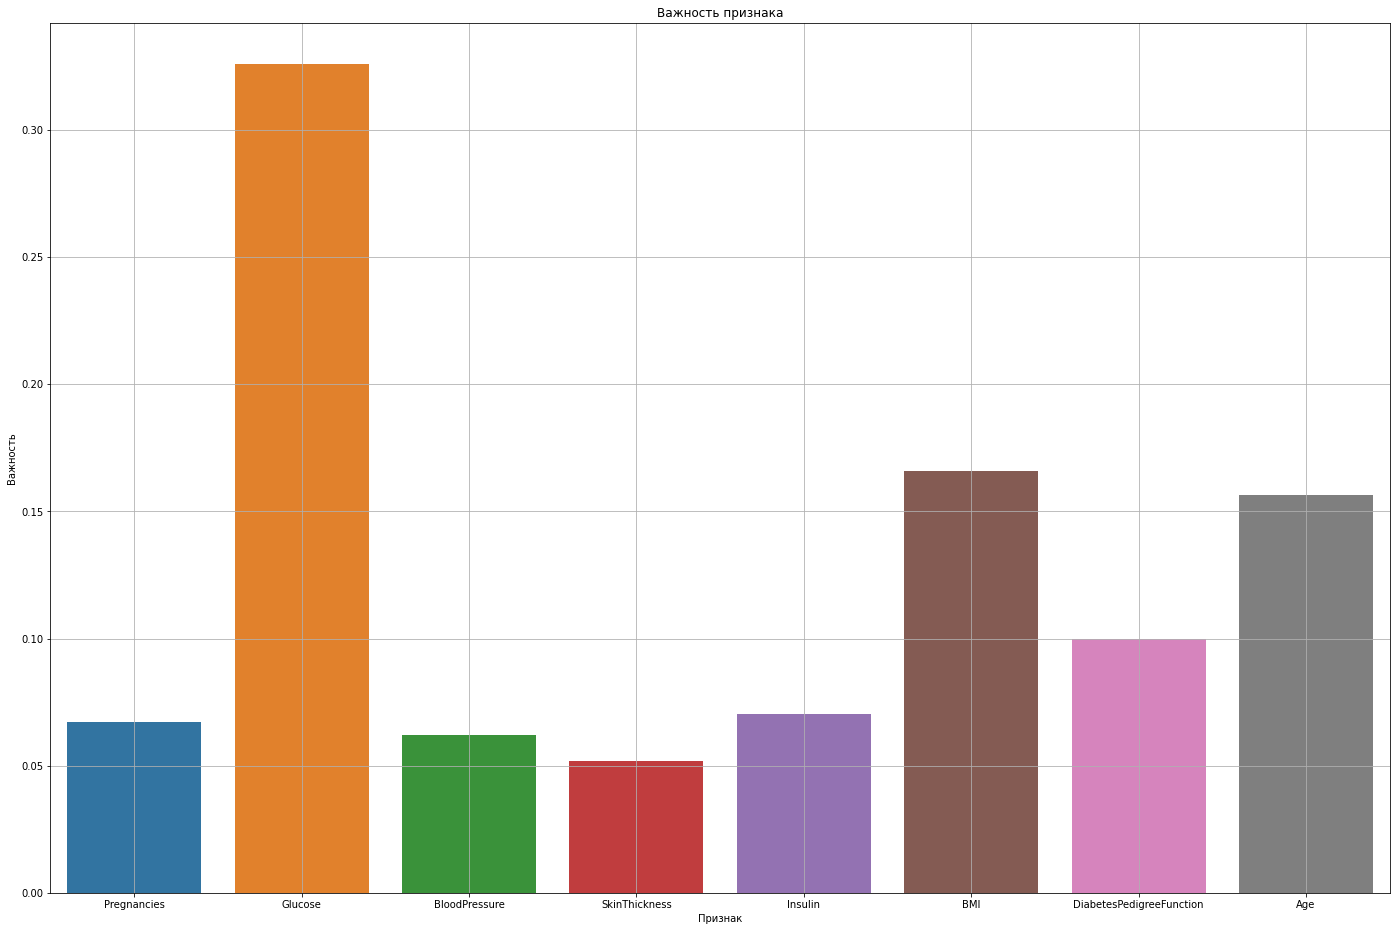

In [191]:
cl = RandomForestClassifier(n_estimators= 40, min_samples_split=15, max_depth= 25)
cl.fit(x_0, y_0)
plt.figure(figsize=(24, 16))
ax = sns.barplot(x=x.columns, y=cl.feature_importances_)
ax.set_xlabel("Признак")
ax.set_ylabel("Важность")
ax.set_title("Важность признака")
plt.grid()
plt.show()

Самым важным с точки зрения дерева признаком оказался: Glucose(Глюкоза), что в принципе логично.